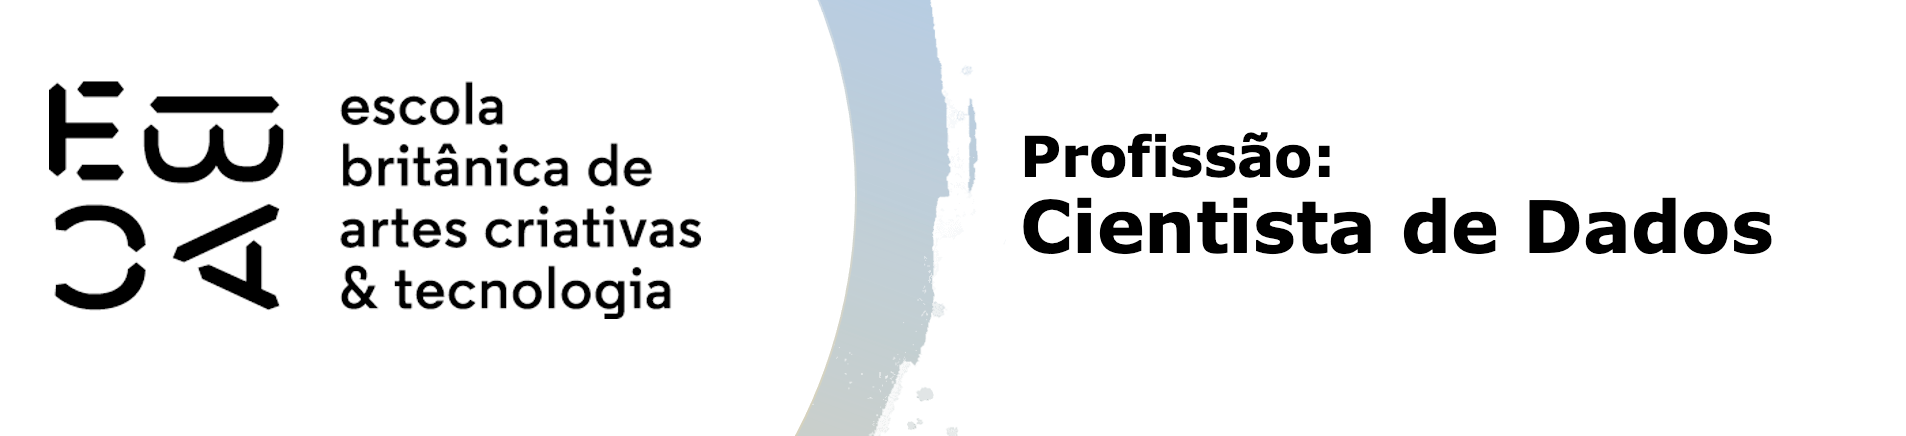

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df['VisitorType'].unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [5]:
# Criando novo DF apenas com as variáveis de escopo
df_escopo = df[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']]
df_escopo

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,0,0.0,0,0.0,1,0.000000
1,0,0.0,0,0.0,2,64.000000
2,0,0.0,0,0.0,1,0.000000
3,0,0.0,0,0.0,2,2.666667
4,0,0.0,0,0.0,10,627.500000
...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667
12326,0,0.0,0,0.0,5,465.750000
12327,0,0.0,0,0.0,6,184.250000
12328,4,75.0,0,0.0,15,346.000000


In [6]:
# Verificando valores faltantes
df_escopo.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
dtype: int64

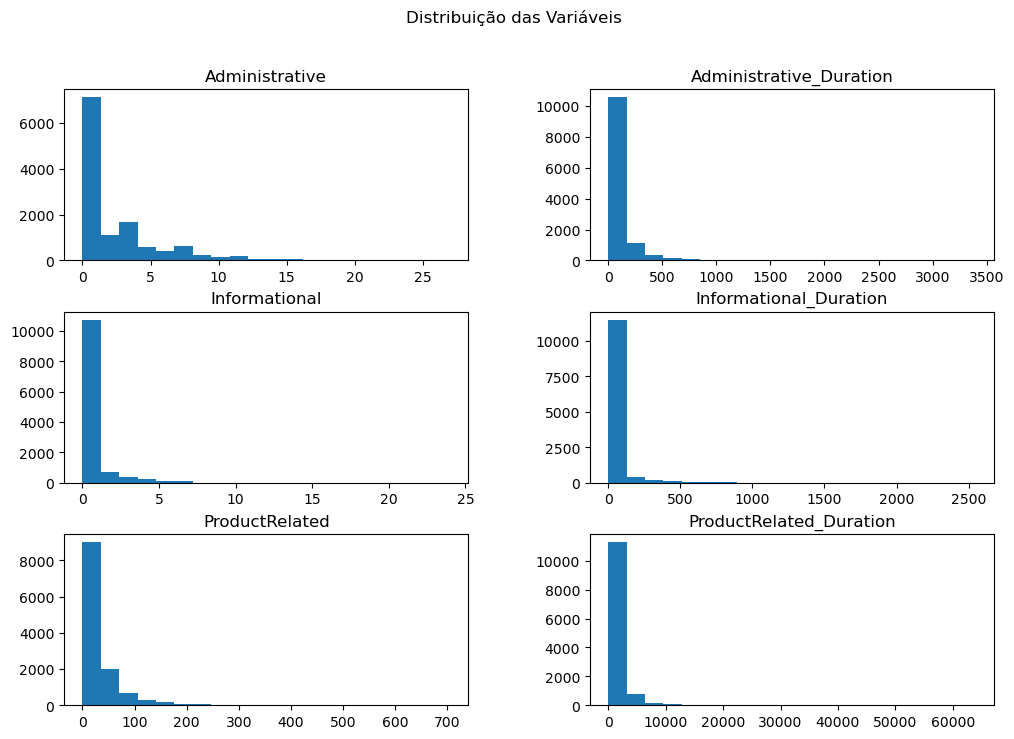

In [7]:
# Verificando a distribuição dos valores de cada variável
df_escopo.hist(figsize=(12, 8), bins=20, grid=False)
plt.suptitle("Distribuição das Variáveis")
plt.show()

## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

#### Utilizando "método do cotovelo" para ter uma ideia da quantidade ideal de clusters

In [8]:
k_clusters = range(2, 8) # Definindo quantidade de clusters a serem testados
inercia = [] # Lista para guardar os valor da soma das distâncias ao centroide


for k in k_clusters:
    kmeans = KMeans(n_clusters = k, random_state = 1) # Definindo a quantidade de clusters(2 a 8)
    kmeans.fit(df_escopo) # Ajustando o modelo aos dados
    inercia.append(kmeans.inertia_) # Adicionando a lista inercia a distância dos valores ao centroide

C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

In [9]:
inercia # Valores dos clusters 2 ao 8, da soma dos quadrados da distância ao centroide

[21544690597.166508,
 13210342750.253872,
 8814853117.433735,
 6023715879.2052355,
 4407869296.45261,
 3319231255.022934]

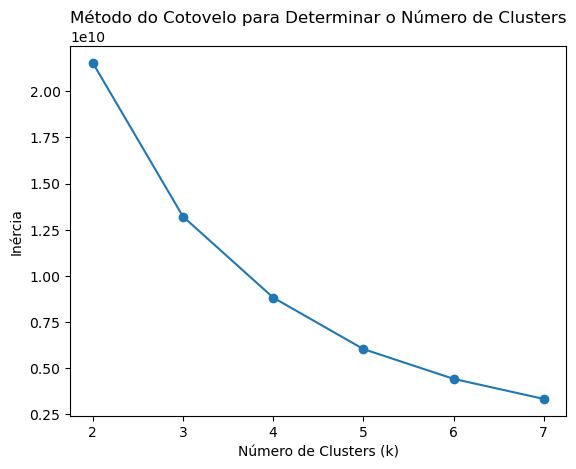

In [10]:
plt.plot(k_clusters, inercia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número de Clusters')
plt.show()

#### Como no gráfico ainda não ficou claro para mim sobre a quebra dos valores por clusters, calculei os valores proporcionais para saber o quanto representam em porcentagem.

In [11]:
soma_total = sum(inercia)
inercia_proporcional = []
for k in inercia:
    inercia_proporcional.append(round((k/soma_total)*100, 2))
    
inercia_proporcional

[37.59, 23.05, 15.38, 10.51, 7.69, 5.79]

In [12]:
num_clusters = 2 #Define o número de clusters a usar
df_escopo_2 = df_escopo.copy() # Criando novo DF para salvar na coluna Cluster os 3 grupos
kmeans = KMeans(n_clusters=num_clusters, random_state=1) #Faz a divisão dos dados nos seus clusters
df_escopo_2['Cluster'] = kmeans.fit_predict(df_escopo) #Rotula cada dado na nova coluna Cluster

C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Gráfico para um agrupamento de 2 grupos

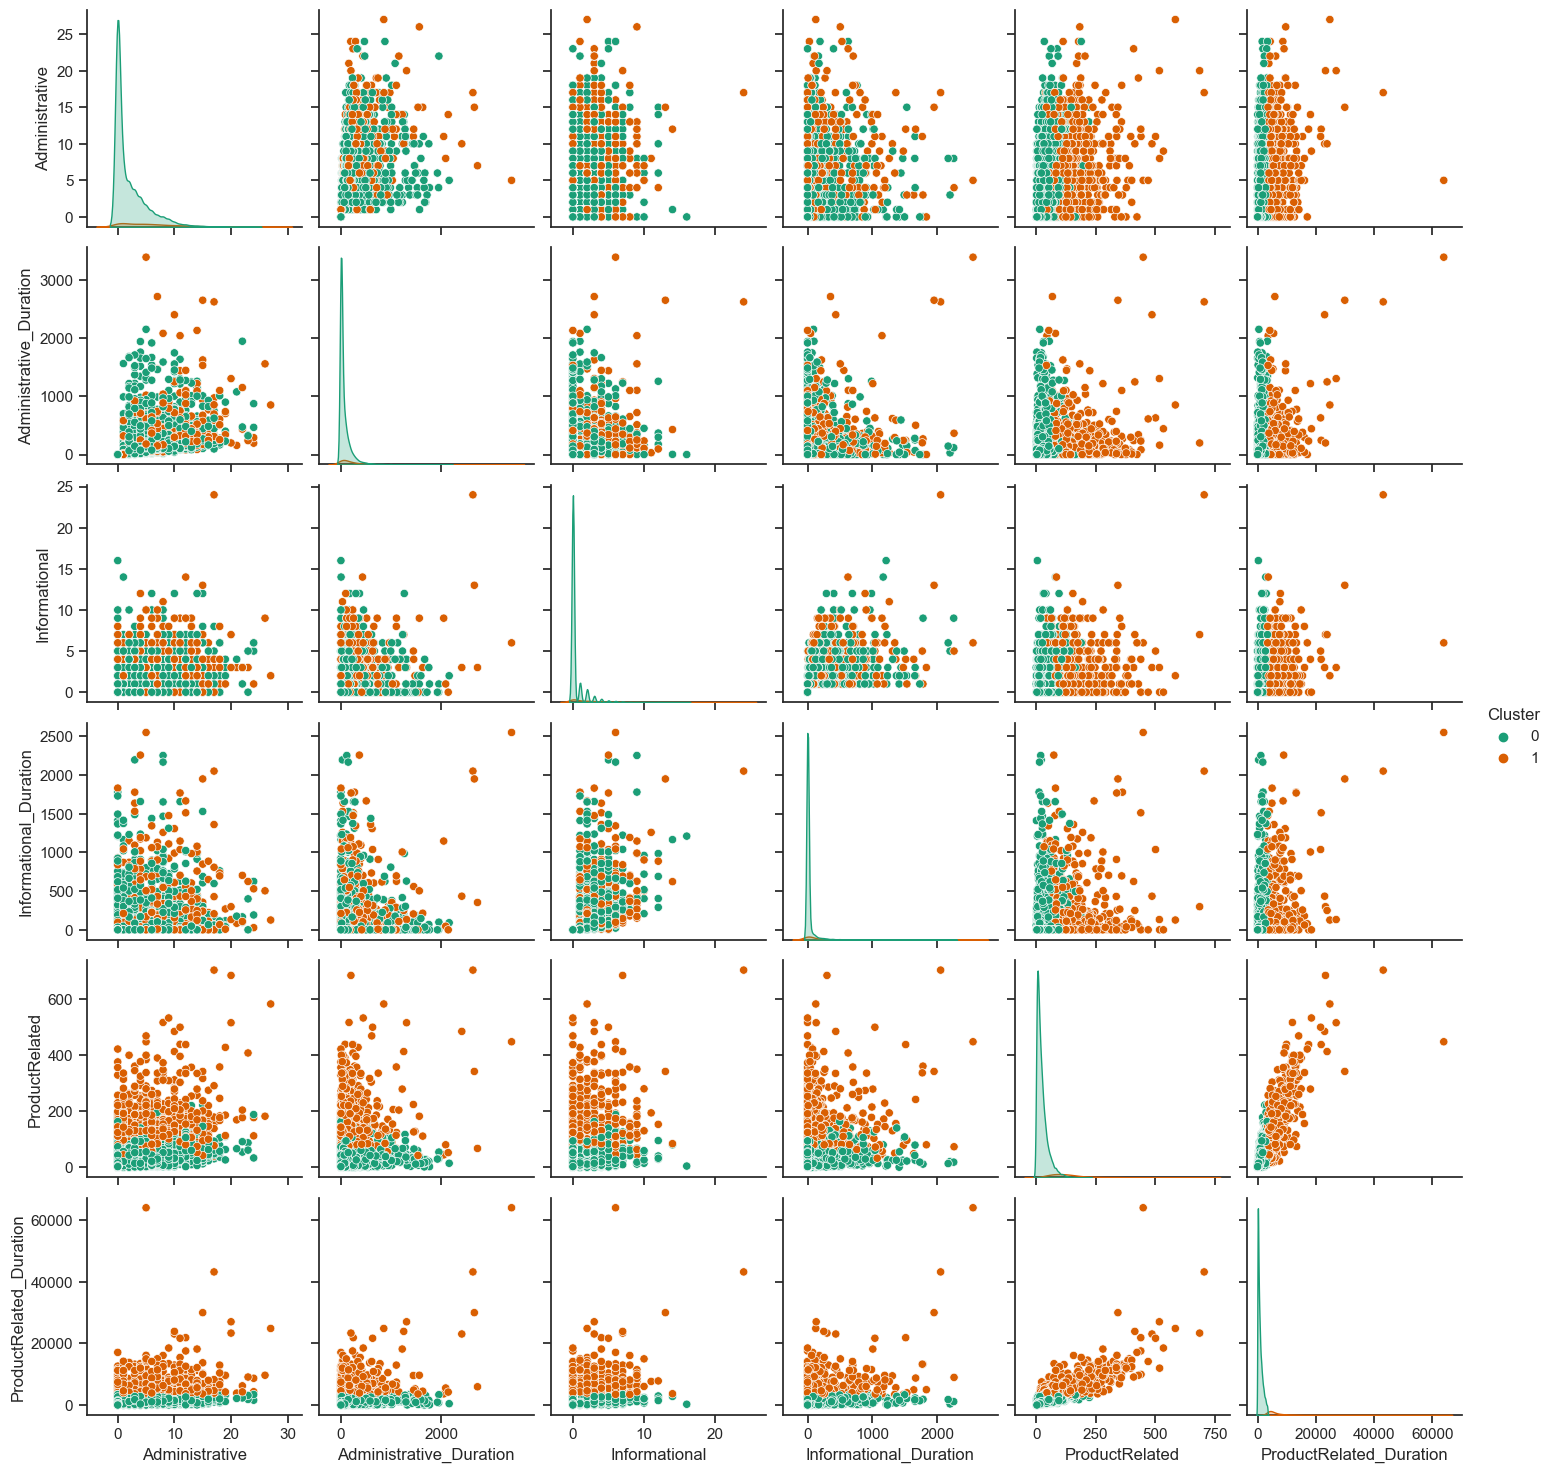

In [13]:
sns.set(style="ticks")
sns.pairplot(df_escopo_2, hue='Cluster', palette='Dark2')
plt.show()

In [14]:
num_clusters = 3 #Define o número de clusters a usar
df_escopo_3 = df_escopo.copy() # Criando novo DF para salvar na coluna Cluster os 3 grupos
kmeans = KMeans(n_clusters=num_clusters, random_state=1) #Faz a divisão dos dados nos seus clusters
df_escopo_3['Cluster'] = kmeans.fit_predict(df_escopo) #Rotula cada dado na nova coluna Cluster

C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Gráfico para um agrupamento de 3 grupos

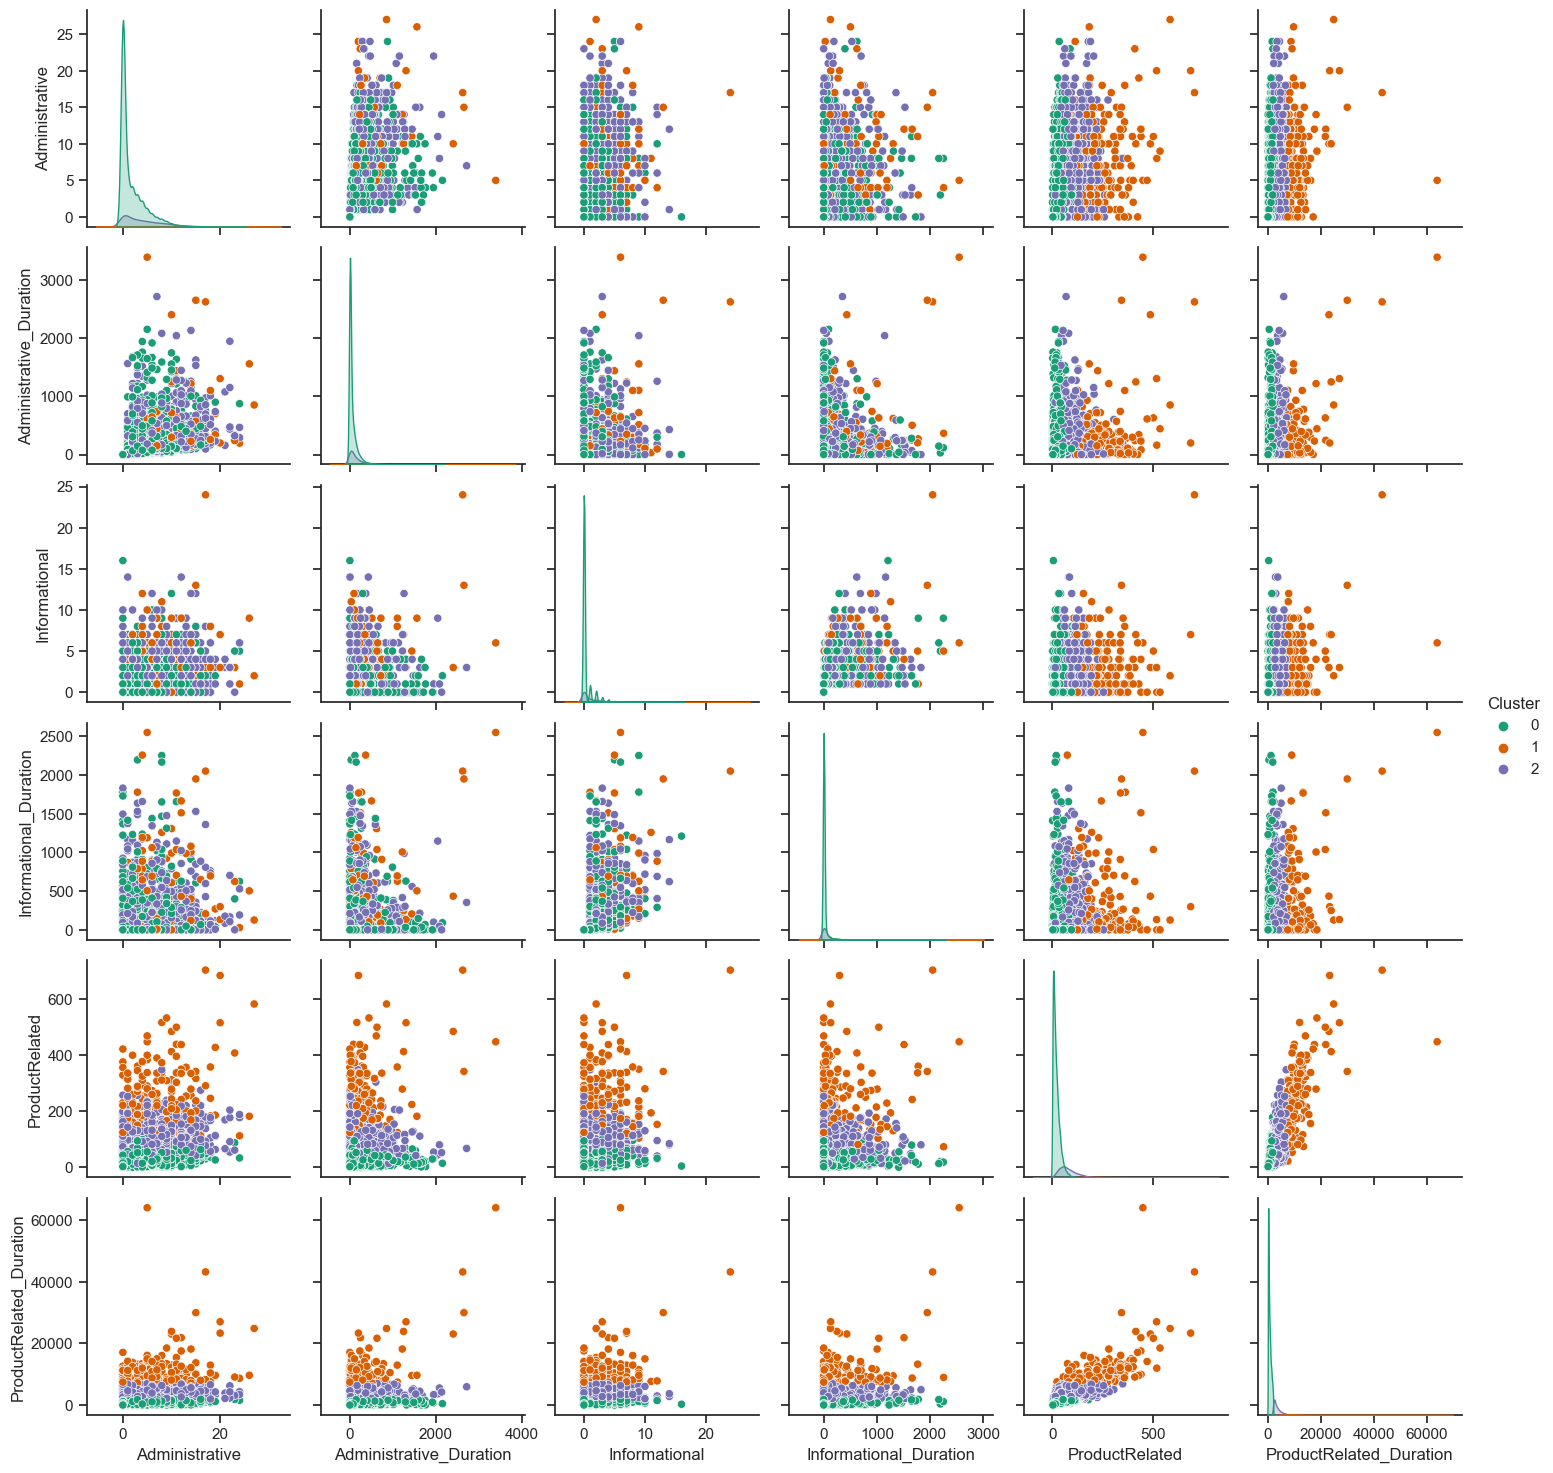

In [15]:
sns.set(style="ticks")
sns.pairplot(df_escopo_3, hue='Cluster', palette='Dark2')
plt.show()

In [16]:
num_clusters = 4 #Define o número de clusters a usar
df_escopo_4 = df_escopo.copy() # Criando novo DF para salvar na coluna Cluster os 4 grupos
kmeans = KMeans(n_clusters=num_clusters, random_state=1) #Faz a divisão dos dados nos seus clusters
df_escopo_4['Cluster'] = kmeans.fit_predict(df_escopo) #Rotula cada dado na nova coluna Cluster

C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Gráfico para um agrupamento de 4 grupos

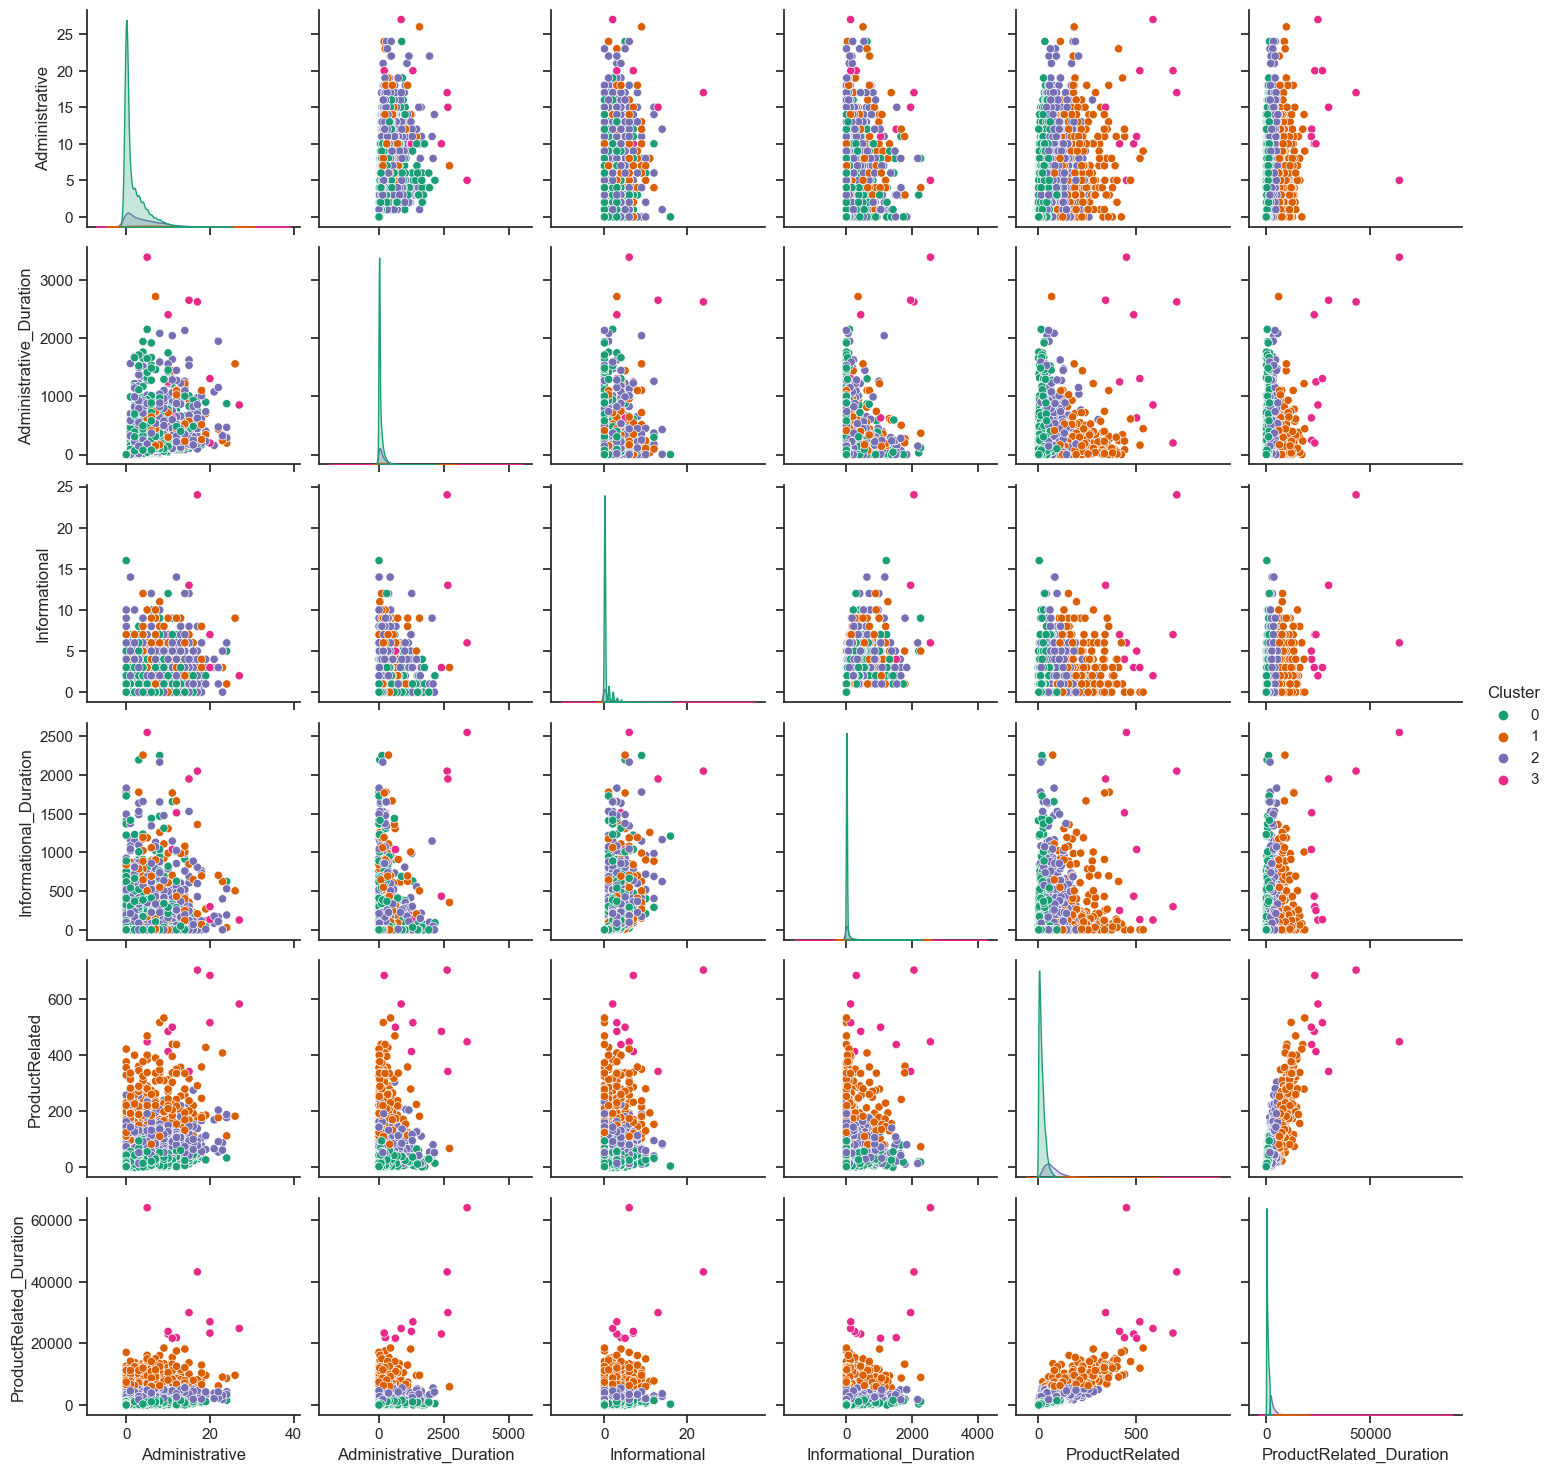

In [17]:
sns.set(style="ticks")
sns.pairplot(df_escopo_4, hue='Cluster', palette='Dark2')
plt.show()

#### Como ainda fiquei na dúvida da quantidade de grupos a usar, foi usado o método silhouette para ajudar na escolha, o método calcula a distância de cada ponto ao seu centroide (grupo) e também calcula a distância de cada ponto a outros pontos de outros centroides, dando assim a informação de o quão bem dividido estão os grupos.

In [18]:
silhouette_score = {}
for k in k_clusters:
    kmeans = KMeans(n_clusters = k, random_state = 1) # Definindo a quantidade de clusters(2 a 8)
    kmeans.fit(df_escopo) # Ajustando o modelo aos dados
    labels = kmeans.predict(df_escopo) # Prevendo os grupos
    silhouette_score[f'{k}'] = metrics.silhouette_score(df_escopo, labels)
    
silhouette_score

C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Bill_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

{'2': 0.7816224489496111,
 '3': 0.6953321839111231,
 '4': 0.675881159765471,
 '5': 0.623622232484241,
 '6': 0.6093108545110166,
 '7': 0.5900529676723791}

#### No caso, os valores acima indicam que 2 grupos estão dividindo melhor os dados que uma quantidade mais elevada, então a analise continuara sendo feita para 2 grupos. 
<br>

#### Obs: Ainda senti a necessidade de maior entendimento dos dados (entendimento do negócio) para tomar uma decisão mais acertiva, mas para fins didativos será continuado para 2 grupos.

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [19]:
df_escopo_2['Cluster'].value_counts()

0    11397
1      933
Name: Cluster, dtype: int64

In [20]:
df_escopo_3['Cluster'].value_counts()

0    10147
2     1976
1      207
Name: Cluster, dtype: int64

#### Estava com dificuldade de decidir qual variável estava separando melhor os dados, então resolvi pegar algumas informações adicionais criando esse novo DataFrame, porém não ajudou o tanto que esperava.

In [21]:
# Realiza a análise descritiva para cada cluster no DataFrame df_escopo_2
descritivo_k2 = df_escopo_2.groupby('Cluster').describe()

# O método stack() é usado para nivelar a tabela gerada pelo groupby e describe
# Isso transforma a tabela em um formato mais longo, facilitando a manipulação e análise
descritivo_k2_stack = descritivo_k2.stack()

# O resultado é um DataFrame chamado df_descritivo_k2, 
# contendo estatísticas descritivas para cada variável, agrupadas por cluster
df_descritivo_k2 = descritivo_k2_stack.reset_index()
df_descritivo_k2

,Cluster,level_1,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,0,count,11397.000000,11397.000000,11397.000000,11397.000000,11397.000000,11397.000000
1,0,mean,2.044222,70.429125,0.401070,25.316980,23.238659,793.739777
2,0,std,2.993964,153.611923,1.083869,112.586841,23.488190,804.515667
3,0,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,25%,0.000000,0.000000,0.000000,0.000000,7.000000,161.666667
5,0,50%,1.000000,0.000000,0.000000,0.000000,16.000000,518.396667
6,0,75%,3.000000,82.000000,0.000000,0.000000,32.000000,1199.616667
7,0,max,24.000000,2156.166667,16.000000,2252.033333,223.000000,3441.806667
8,1,count,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000
9,1,mean,5.624866,207.730683,1.755627,146.309803,135.474812,6093.213995


#### Aqui tive a ideia de usar o resultado do Cluster como se fosse a variável resposta, já que a árvore de decisão deixa no seu nó principal a principal pergunta que é relacionada a alguma variável utilizada, então criei a árvore para ajudar a identificar a variável que está melhor dividindo os dados.
<br>

#### Nesse caso foi a o ProductRelated_Duration, o que olhando nos gráficos anteriores é possível ter essa noção, mas pode ser confundido com o ProductRelated que também separa bem os dados.

In [22]:
# Remova a coluna 'Cluster' antes de treinar o modelo de árvore de decisão
X = df_escopo_2.drop(columns=['Cluster'])

# Use os rótulos dos clusters obtidos do KMeans como variável de destino
y = df_escopo_2['Cluster']

# Crie e ajuste o modelo de árvore de decisão
tree_model = DecisionTreeClassifier(random_state=1)
tree_model.fit(X, y)

# Exiba a árvore de decisão em texto
tree_rules = export_text(tree_model, feature_names=X.columns.tolist())
print("Árvore de Decisão:")
print(tree_rules)

Árvore de Decisão:
|--- ProductRelated_Duration <= 3443.41
|   |--- ProductRelated_Duration <= 3438.35
|   |   |--- class: 0
|   |--- ProductRelated_Duration >  3438.35
|   |   |--- ProductRelated_Duration <= 3440.59
|   |   |   |--- class: 1
|   |   |--- ProductRelated_Duration >  3440.59
|   |   |   |--- class: 0
|--- ProductRelated_Duration >  3443.41
|   |--- class: 1



#### Interpretação da árvore:

##### Primeira pergunta: ProductRelated_Duration <= 3443.41
##### Esse é o primeiro nó, pergunta se o tempo total gasto em página produto relacionado é menor ou igual a 3443.41, se sim, vai para esquerda, se não, vai para direita, se for para a direita, ou seja, ProductRelated_Duration >  3443.41 que é a ultima pergunta na árvore acima, então é classe 1
<br>

##### Segunda pergunta: ProductRelated_Duration <= 3438.35
##### Essa é a esquerda do primeiro nó, se o ProductRelated_Duration for menor ou igual a 3438.35, então sua classe vai ser 0, se não ele segue para a próxima pergunta que é ProductRelated_Duration >  3438.35 que está na terceira pergunta e continua.
<br>

##### Quarta pergunta: ProductRelated_Duration <= 3440.59
##### Caso a pergunta anterior seja ProductRelated_Duration >  3438.35, é então feita a quarta pergunta e se o ProductRelated_Duration for menor ou igual a 3440.59, então ele é classe 1, do contrário se for maior que 3440.59, então é classe 0.

#### Aqui é feito uma comparação com os resultados da coluna 'Cluster', obtidos pelo kmeans e os resultados de 'Cluster_tree', obtidos pela árvore criada usando o próprio resultado do kmeans como y. Para minha surpresa foi obtido um resultado identico. 
<br>

#### Por um lado isso é bom pois me da a certeza de que o ProductRelated_Duration realmente é o melhor separador para ambos os casos, mas trás uma insegurança de que algo possa ter sido feito errado.

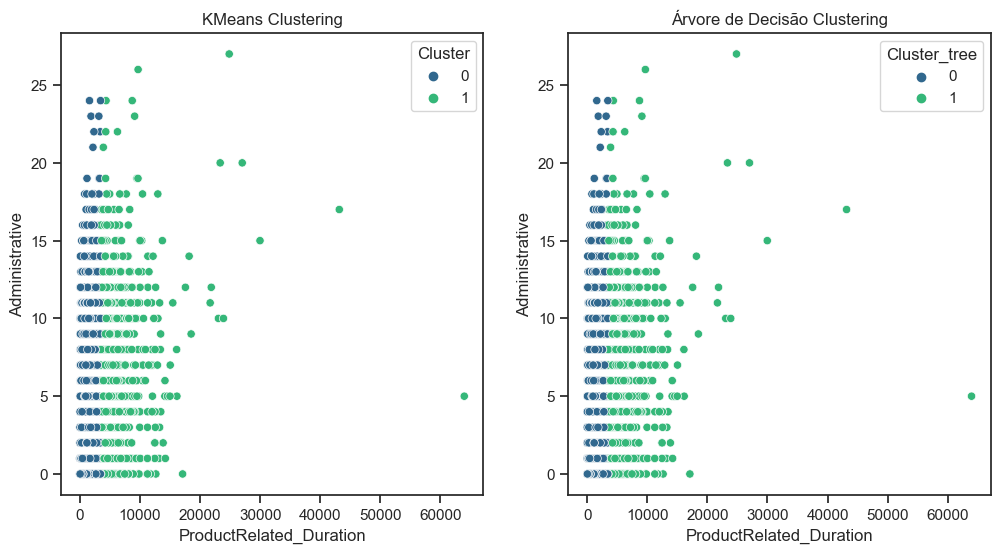

In [23]:
# Fazendo uma cópia do df_escopo para salvar os resultados da árvore
df_escopo_2_tree = df_escopo_2.copy()
df_escopo_2_tree['Cluster_tree'] = tree_model.predict(X)

# Tamanho do gráfico
plt.figure(figsize=(12, 6))

# Gráfico de dispersão para KMeans, usando o hue como Cluster
plt.subplot(1, 2, 1)
sns.scatterplot(x='ProductRelated_Duration', y='Administrative', hue='Cluster', data=df_escopo_2_tree, palette='viridis', legend='full')
plt.title('KMeans Clustering')

# Gráfico de dispersão para Árvore de Decisão, usando o hue como Cluster_tree
plt.subplot(1, 2, 2)
sns.scatterplot(x='ProductRelated_Duration', y='Administrative', hue='Cluster_tree', data=df_escopo_2_tree, palette='viridis', legend='full')
plt.title('Árvore de Decisão Clustering')

# Mostrar os gráficos
plt.show()

#### Como o gráfico ficou identico, resolvi criar mais uma coluna que salva como 'igual' caso o resultado do DataFrame df_escopo_2 seja igual ao df_escopo_2_tree e 'diferente' caso contrário, mas os resultados foram realmente identicos, 100% igual.

In [24]:
df_escopo_2_tree['Classificação_Igual'] = np.where(df_escopo_2_tree['Cluster'] == df_escopo_2_tree['Cluster_tree'], 'Igual', 'Diferente')
soma_classificacao_igual = (df_escopo_2_tree['Classificação_Igual'] == 'Igual').sum()
print(f'Número de linhas do DataFrame: {df_escopo_2_tree.shape[0]}')
print(f'Número de linhas do que tem resultado igual: {soma_classificacao_igual}')

Número de linhas do DataFrame: 12330
Número de linhas do que tem resultado igual: 12330


#### Repetindo o processo para 3 grupos.

In [25]:
# Remova a coluna 'Cluster' antes de treinar o modelo de árvore de decisão
X = df_escopo_3.drop(columns=['Cluster'])

# Use os rótulos dos clusters obtidos do KMeans como variável de destino
y = df_escopo_3['Cluster']

# Crie e ajuste o modelo de árvore de decisão
tree_model = DecisionTreeClassifier(random_state=1)
tree_model.fit(X, y)

# Exiba a árvore de decisão em texto
tree_rules = export_text(tree_model, feature_names=X.columns.tolist())
print("Árvore de Decisão:")
print(tree_rules)

Árvore de Decisão:
|--- ProductRelated_Duration <= 1966.94
|   |--- ProductRelated_Duration <= 1955.90
|   |   |--- class: 0
|   |--- ProductRelated_Duration >  1955.90
|   |   |--- ProductRelated_Duration <= 1957.56
|   |   |   |--- class: 2
|   |   |--- ProductRelated_Duration >  1957.56
|   |   |   |--- class: 0
|--- ProductRelated_Duration >  1966.94
|   |--- ProductRelated_Duration <= 7121.78
|   |   |--- ProductRelated_Duration <= 1970.42
|   |   |   |--- ProductRelated_Duration <= 1969.47
|   |   |   |   |--- class: 2
|   |   |   |--- ProductRelated_Duration >  1969.47
|   |   |   |   |--- ProductRelated <= 37.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ProductRelated >  37.00
|   |   |   |   |   |--- class: 2
|   |   |--- ProductRelated_Duration >  1970.42
|   |   |   |--- class: 2
|   |--- ProductRelated_Duration >  7121.78
|   |   |--- class: 1



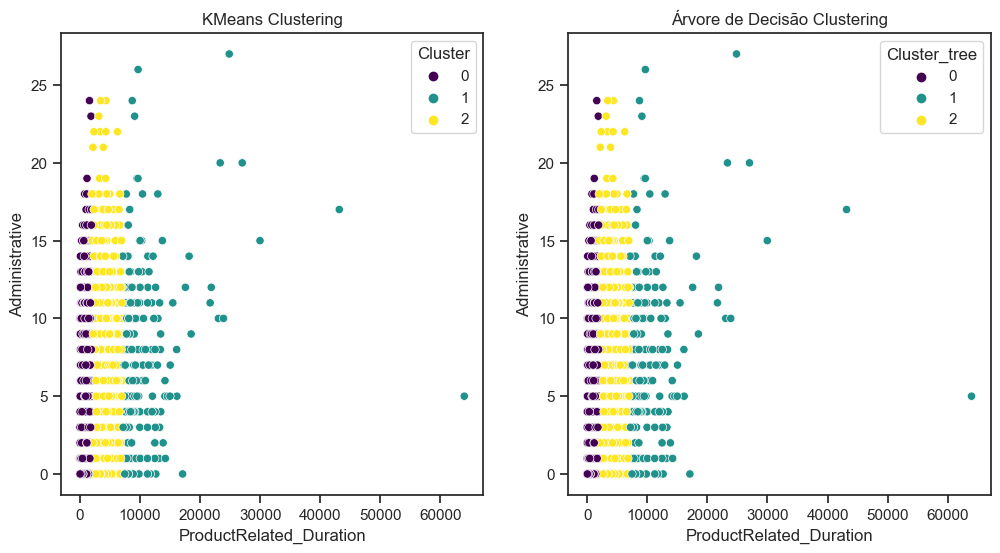

In [26]:
# Fazendo uma cópia do df_escopo para salvar os resultados da árvore
df_escopo_3_tree = df_escopo_3.copy()
df_escopo_3_tree['Cluster_tree'] = tree_model.predict(X)

# Tamanho do gráfico
plt.figure(figsize=(12, 6))

# Gráfico de dispersão para KMeans, usando o hue como Cluster
plt.subplot(1, 2, 1)
sns.scatterplot(x='ProductRelated_Duration', y='Administrative', hue='Cluster', data=df_escopo_3_tree, palette='viridis', legend='full')
plt.title('KMeans Clustering')

# Gráfico de dispersão para Árvore de Decisão, usando o hue como Cluster_tree
plt.subplot(1, 2, 2)
sns.scatterplot(x='ProductRelated_Duration', y='Administrative', hue='Cluster_tree', data=df_escopo_3_tree, palette='viridis', legend='full')
plt.title('Árvore de Decisão Clustering')

# Mostrar os gráficos
plt.show()

#### Novamente identicos, só que dessa vez a árvore chegou a usar o ProductRelated para fazer mais uma divisão de nós.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [30]:
# Criando um novo DF para adicionar o Bounce e o Revenue
df_compra_k2 =  df_escopo_2.copy()
df_compra_k2['BounceRates'] = df['BounceRates']
df_compra_k2['Revenue'] = df['Revenue']
df_compra_k2

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Cluster,BounceRates,Revenue
0,0,0.0,0,0.0,1,0.000000,0,0.200000,False
1,0,0.0,0,0.0,2,64.000000,0,0.000000,False
2,0,0.0,0,0.0,1,0.000000,0,0.200000,False
3,0,0.0,0,0.0,2,2.666667,0,0.050000,False
4,0,0.0,0,0.0,10,627.500000,0,0.020000,False
...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0,0.007143,False
12326,0,0.0,0,0.0,5,465.750000,0,0.000000,False
12327,0,0.0,0,0.0,6,184.250000,0,0.083333,False
12328,4,75.0,0,0.0,15,346.000000,0,0.000000,False


In [34]:
# Verificando o total de clientes que compraram
total_true = (df_compra_k2['Revenue'] == True).sum()
total_true

1908

In [50]:
# Salvando os valores totais do grupo 0 e 1 nas respectivas variáveis
grupo_0 = (df_compra_k2['Cluster'] == 0).sum()
grupo_1 = (df_compra_k2['Cluster'] == 1).sum()

# Salvando o total de valores True para Cluster 0 e Cluster 1
grupo_revenue_true = df_compra_k2[df_compra_k2['Revenue'] == True]['Cluster'].value_counts()

print(f'Total do grupo 0: {grupo_0}')
print(f'Total do grupo 1: {grupo_1}\n')
print(f'Total do grupo 0 e 1 que comparam: \n{grupo_revenue_true}\n')
print(f'Total proporcional do grupo 0 que compraram: {grupo_revenue_true[0] / grupo_0 * 100:.2f}%')
print(f'Total proporcional do grupo 1 que compraram: {grupo_revenue_true[1] / grupo_1 * 100:.2f}%')



Total do grupo 0: 11397
Total do grupo 1: 933

Total do grupo 0 e 1 que comparam: 
0    1625
1     283
Name: Cluster, dtype: int64

Total proporcional do grupo 0 que compraram: 14.26%
Total proporcional do grupo 1 que compraram: 30.33%


In [64]:
# Verificando o tempo médio gasto nas páginas relacionadas a compra pelo grupo 0 e 1, dos que compraram
# e dos que não comparam

media_tempo = df_compra_k2.groupby(['Cluster', 'Revenue'])['ProductRelated_Duration'].mean()
media_tempo

Cluster  Revenue
0        False       740.355402
         True       1114.768766
1        False      6025.630703
         True       6248.440637
Name: ProductRelated_Duration, dtype: float64

#### Deu para perceber que clientes que gastam mais tempo em páginas de compra tem maior tendencia a comprar os produtos, por isso essa variável foi usada como principal divisora dos grupos no k-means e na árvore.
<br>

#### Repetindo os passos anteriores para 3 grupos.

In [74]:
# Criando um novo DF para adicionar o Bounce e o Revenue
df_compra_k3 =  df_escopo_3.copy()
df_compra_k3['BounceRates'] = df['BounceRates']
df_compra_k3['Revenue'] = df['Revenue']
df_compra_k3

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Cluster,BounceRates,Revenue
0,0,0.0,0,0.0,1,0.000000,0,0.200000,False
1,0,0.0,0,0.0,2,64.000000,0,0.000000,False
2,0,0.0,0,0.0,1,0.000000,0,0.200000,False
3,0,0.0,0,0.0,2,2.666667,0,0.050000,False
4,0,0.0,0,0.0,10,627.500000,0,0.020000,False
...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0,0.007143,False
12326,0,0.0,0,0.0,5,465.750000,0,0.000000,False
12327,0,0.0,0,0.0,6,184.250000,0,0.083333,False
12328,4,75.0,0,0.0,15,346.000000,0,0.000000,False


In [75]:
# Verificando o total de clientes que compraram
total_true = (df_compra_k3['Revenue'] == True).sum()
total_true

1908

In [83]:
# Salvando os valores totais do grupo 0, 1 e 2 nas respectivas variáveis
grupo_0 = (df_compra_k3['Cluster'] == 0).sum()
grupo_1 = (df_compra_k3['Cluster'] == 1).sum()
grupo_2 = (df_compra_k3['Cluster'] == 2).sum()

# Salvando o total de valores True para Cluster 0 e Cluster 1
grupo_revenue_true = df_compra_k3[df_compra_k3['Revenue'] == True]['Cluster'].value_counts()

print(f'Total do grupo 0: {grupo_0}')
print(f'Total do grupo 1: {grupo_1}')
print(f'Total do grupo 2: {grupo_2}\n')

print(f'Total do grupo 0, 1 e 2 que compraram: \n{grupo_revenue_true}\n')

print(f'Total proporcional do grupo 0 que compraram: {grupo_revenue_true[0] / grupo_0 * 100:.2f}%')
print(f'Total proporcional do grupo 1 que compraram: {grupo_revenue_true[1] / grupo_1 * 100:.2f}%')
print(f'Total proporcional do grupo 2 que compraram: {grupo_revenue_true[2] / grupo_2 * 100:.2f}%')

Total do grupo 0: 10147
Total do grupo 1: 207
Total do grupo 2: 1976

Total do grupo 0, 1 e 2 que compraram: 
0    1342
2     496
1      70
Name: Cluster, dtype: int64

Total proporcional do grupo 0 que compraram: 13.23%
Total proporcional do grupo 1 que compraram: 33.82%
Total proporcional do grupo 2 que compraram: 25.10%


In [82]:
grupo_revenue_true

0    1342
2     496
1      70
Name: Cluster, dtype: int64

In [84]:
# Verificando o tempo médio gasto nas páginas relacionadas a compra pelo grupo 0 e 1, dos que compraram
# e dos que não comparam

media_tempo = df_compra_k3.groupby(['Cluster', 'Revenue'])['ProductRelated_Duration'].mean()
media_tempo

Cluster  Revenue
0        False        540.970489
         True         809.411626
1        False      11084.542356
         True       10497.939869
2        False       3290.260466
         True        3545.809983
Name: ProductRelated_Duration, dtype: float64

### Conclusões:
#### Na divisão em 3 grupos o grupo 0 fez o papel do mesmo grupo 0 quando a divisão foi feita em 2, o grupo 0 não passa muito tempo em páginas dos produtos e acabam sendo menos propensos a compra. Os grupos 1 e 2 são mais propensos as compras, ao verificar o tempo médio nas páginas de produto quanto maior a taxa de compra do grupo em questão, menor a diferença do tempo de True e False, isso quer dizer que aquele grupo em questão já está bem dividido como o cliente que é comprador.
<br>

#### Então ficou da seguinte maneira:
#### Grupo 1, cliente com alta chance de compra
#### Grupo 2, cliente com chance boa de compra
#### Grupo 0, cliente que provavelmente não vai comprar